In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 140 kB 41.7 MB/s 
     |████████████████████████████████| 180 kB 49.3 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=01aceaf166204e976a701594c4b7710c17159f1ca179cd2393625b10ba967e4d
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=2a1aefdc2a8c9f7a7719d370c44b4da88d94eb05e3596608d9e673c3b8b94869
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
import tensorflow as tf

import wandb

from keras import layers, models
import numpy as np
import tensorflow as tf
from tensorflow.keras import optimizers, metrics
import numpy as np

import wandb
from wandb.keras import WandbCallback



from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence,to_categorical

from PIL import Image

import numpy as np
import random




# from libs import datasets_keras
# from libs.config import LABELMAP
# from libs.util_keras import FBeta
import numpy as np

import wandb
from wandb.keras import WandbCallback



from keras.metrics import Metric
from keras import backend as K
from keras.utils import metrics_utils
import numpy as np



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def build_unet(size=300, basef=64, maxf=512, encoder='resnet50', pretrained=True):
    input = layers.Input((size, size, 3))

    encoder_model = make_encoder(input, name=encoder, pretrained=pretrained)

    crosses = []
    print("all" , encoder_model.layers)

    for layer in encoder_model.layers:
      print('abc ', layer.output_shape);
      print('abc 1 ',type(layer.output_shape));
      

    for layer in encoder_model.layers:
        # don't end on padding layers
        if type(layer) == layers.ZeroPadding2D:
            continue
        print('hhe ', layer.output_shape)
        idx = None
        if type(layer.output_shape) is list :
          print("list : " , layer.output_shape[0][1])
          idx = get_scale_index(size, layer.output_shape[0][1])
        
        if type(layer.output_shape) is tuple:
          print("tuple : " , layer.output_shape[1])
          idx = get_scale_index(size, layer.output_shape[1])
           
        # idx = get_scale_index(size, layer.output_shape[0])
        print('idx' , idx)
        if idx is None:
            continue
        if idx >= len(crosses):
            crosses.append(layer)
        else:
            crosses[idx] = layer

    print('crosses : ' , crosses)
    x = crosses[-1].output
    for scale in range(len(crosses)-2, -1, -1):
        nf = min(basef * 2**scale, maxf)
        x = upscale(x, nf)
        x = act(x)
        x = layers.Concatenate()([
            pad_to_scale(x, scale, size=size),
            pad_to_scale(crosses[scale].output, scale, size=size)
        ])
        x = conv(x, nf)
        x = act(x)

    x = conv(x, 6)
    x = layers.Activation('softmax')(x)

    return models.Model(input, x)

def make_encoder(input, name='resnet50', pretrained=True):
    if name == 'resnet18':
        from classification_models.keras import Classifiers
        ResNet18, _ = Classifiers.get('resnet18')
        model = ResNet18(
            weights='imagenet' if pretrained else None,
            input_tensor=input,
            include_top=False
        )
    elif name == 'resnet50':
        from keras.applications.resnet import ResNet50
        model = ResNet50(
            weights='imagenet' if pretrained else None,
            input_tensor=input,
            include_top=False
        )
    elif name == 'resnet101':
        from keras.applications.resnet import ResNet101
        model = ResNet101(
            weights='imagenet' if pretrained else None,
            input_tensor=input,
            include_top=False
        )
    elif name == 'resnet152':
        from keras.applications.resnet import ResNet152
        model = ResNet152(
            weights='imagenet' if pretrained else None,
            input_tensor=input,
            include_top=False
        )
    elif name == 'vgg16':
        from keras.applications.vgg16 import VGG16
        model = VGG16(
            weights='imagenet' if pretrained else None,
            input_tensor=input,
            include_top=False
        )
    elif name == 'vgg19':
        from keras.applications.vgg19 import VGG19
        model = VGG19(
            weights='imagenet' if pretrained else None,
            input_tensor=input,
            include_top=False
        )
    else:
        raise Exception(f'unknown encoder {name}')

    return model

def get_scale_index(in_size, l_size):
    for i in range(8):
        s_size = in_size // (2 ** i)
        if abs(l_size - s_size) <= 4:
            return i
    return None

def pad_to_scale(x, scale, size=300):
    expected = int(np.ceil(size / (2. ** scale)))
    diff = expected - int(x.shape[1])
    if diff > 0:
        left = diff // 2
        right = diff - left
        x = reflectpad(x, (left, right))
    elif diff < 0:
        left = -diff // 2
        right = -diff - left
        x = layers.Cropping2D(((left, right), (left, right)))(x)
    return x

def reflectpad(x, pad):
    return layers.Lambda(lambda x: tf.pad(x, [(0, 0), pad, pad, (0, 0)], 'REFLECT'))(x)

def upscale(x, nf):
    x = layers.UpSampling2D((2, 2))(x)
    x = conv(x, nf, kernel_size=(1, 1))
    return x

def act(x):
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    return x

def conv(x, nf, kernel_size=(3, 3), **kwargs):
    padleft = (kernel_size[0] - 1) // 2
    padright = kernel_size[0] - 1 - padleft
    if padleft > 0 or padright > 0:
        x = reflectpad(x, (padleft, padright))
    return layers.Conv2D(nf, kernel_size=kernel_size, padding='valid', **kwargs)(x)



In [ ]:
# adapted from keras.metrics.Precision
class FBeta(Metric):
    def __init__(self,
                 beta=1,
                 name=None,
                 dtype=None):
        super(FBeta, self).__init__(name=name, dtype=dtype)
        self.beta2 = beta*beta
        self.true_positives = self.add_weight(
            'true_positives',
            shape=(1,),
            initializer='zeros')
        self.false_positives = self.add_weight(
            'false_positives',
            shape=(1,),
            initializer='zeros')
        self.false_negatives = self.add_weight(
            'false_negatives',
            shape=(1,),
            initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        return metrics_utils.update_confusion_matrix_variables(
            {
                metrics_utils.ConfusionMatrix.TRUE_POSITIVES: self.true_positives,
                metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives,
                metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives,
            },
            y_true,
            y_pred,
            thresholds=[metrics_utils.NEG_INF],
            top_k=1,
            class_id=None,
            sample_weight=sample_weight)

    def _precision(self):
        denom = (self.true_positives + self.false_positives)
        result = K.switch(
            K.greater(denom, 0),
            self.true_positives / denom,
            K.zeros_like(self.true_positives))
        return result[0]

    def _recall(self):
        denom = (self.true_positives + self.false_negatives)
        result = K.switch(
            K.greater(denom, 0),
            self.true_positives / denom,
            K.zeros_like(self.true_positives))
        return result[0]

    def result(self):
        precision, recall = self._precision(), self._recall()
        denom = self.beta2 * precision + recall
        result = K.switch(
            K.greater(denom, 0),
            (1 + self.beta2) * precision * recall / denom,
            0.)
        return result

    def reset_states(self):
        K.batch_set_value(
            [(v, np.zeros((1,))) for v in self.weights])

    def get_config(self):
        config = {
            'beta2': self.beta2
        }
        base_config = super(FBeta, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:


def load_dataset(dataset, bs, aug={'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 180, 'zoom_range' : [1.00, 1.10]}):
    train_files = [f'/content/drive/MyDrive/dataset-sample/image-chips/{fname}' for fname in load_lines(f'/content/drive/MyDrive/dataset-sample/train.txt')]
    valid_files = [f'/content/drive/MyDrive/dataset-sample/image-chips/{fname}' for fname in load_lines(f'/content/drive/MyDrive/dataset-sample/valid.txt')]
    
    train_seq = SegmentationSequence(
        dataset,
        train_files, 
        ImageDataGenerator(**aug),
        bs
    )
    
    valid_seq = SegmentationSequence(
        dataset,
        valid_files,
        ImageDataGenerator(), # don't augment validation set
        bs
    )
    
    return train_seq, valid_seq

def load_lines(fname):
    with open(fname, 'r') as f:
        return [l.strip() for l in f.readlines()]

def load_img(fname):
    return np.array(Image.open(fname))

def mask_to_classes(mask):
    return to_categorical(mask[:,:,0], 6)

class SegmentationSequence(Sequence):
    def __init__(self, dataset, image_files, datagen, bs):
        self.label_path = f'/content/drive/MyDrive/dataset-sample/label-chips'
        self.image_path = f'/content/drive/MyDrive/dataset-sample/image-chips'
        self.image_files = image_files
        random.shuffle(self.image_files)

        self.datagen = datagen
        self.bs = bs
        self.n = 0
        self.max = self.__len__()

    def __len__(self):
        return int(np.ceil(len(self.image_files) / float(self.bs)))

    def __getitem__(self, idx):
        image_files = self.image_files[idx*self.bs:(idx+1)*self.bs]
        label_files = [fname.replace(self.image_path, self.label_path) for fname in image_files]

        images = [load_img(fname) for fname in image_files]
        labels = [mask_to_classes(load_img(fname)) for fname in label_files]

        ts = [self.datagen.get_random_transform(im.shape) for im in images]
        images = [self.datagen.apply_transform(im, ts) for im, ts in zip(images, ts)]
        labels = [self.datagen.apply_transform(im, ts) for im, ts in zip(labels, ts)]

        return np.array(images), np.array(labels)

    # def on_epoch_end(self):
    #     random.shuffle(self.image_files)

    def __next__(self):
        if self.n >= self.max:
           self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result




def train_model(dataset, model):

  # Class to color (BGR)
    LABELMAP = {
    0 : (255,   0, 255),
    1 : (75,   25, 230),
    2 : (180,  30, 145),
    3 : (75,  180,  60),
    4 : (48,  130, 245),
    5 : (255, 255, 255),
    6 : (200, 130,   0),
    }

    epochs = 1
#     epochs = 0
    lr     = 1e-4
    size   = 300
    wd     = 1e-2
    # bs     = 8 # reduce this if you are running out of GPU memory
    bs = 2
    pretrained = True

    config = {
        'epochs' : epochs,
        'lr' : lr,
        'size' : size,
        'wd' : wd,
        'bs' : bs,
        'pretrained' : pretrained,
    }

    wandb.config.update(config)
# learning_rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=[
            metrics.Precision(top_k=1, name='precision'),
            metrics.Recall(top_k=1, name='recall'),
            FBeta(name='f_beta')
        ]
    )

    train_data, valid_data = load_dataset(dataset, bs)
    _, ex_data = load_dataset(dataset, 10)
    model.fit_generator(
        train_data,
        validation_data=valid_data,
        epochs=epochs,
        callbacks=[
            WandbCallback(
                input_type='image',
                output_type='segmentation_mask',
                validation_data=ex_data[0]
            )
        ]
    )


In [ ]:

dataset = 'dataset-sample'  #  0.5 GB download
    # dataset = 'dataset-medium' # 9.0 GB download

config = {
        'name' : 'baseline-keras',
        'dataset' : dataset,
    }
wandb.init(config=config)
# train the model
model = build_unet(encoder='resnet50')

with tf.device("gpu"):
  train_model(dataset, model)

# # use the train model to run inference on all test scenes
# inference_keras.run_inference(dataset, model=model, basedir=wandb.run.dir)

# # scores all the test images compared to the ground truth labels then
# # send the scores (f1, precision, recall) and prediction images to wandb
# score, _ = scoring.score_predictions(dataset, basedir=wandb.run.dir)
# print(score)
# wandb.log(score)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


94781440/94765736 [==============================] - 1s 0us/step
all [<keras.engine.input_layer.InputLayer object at 0x7f16e9aa3a10>, <keras.layers.convolutional.ZeroPadding2D object at 0x7f16e9bb0110>, <keras.layers.convolutional.Conv2D object at 0x7f16e56a1350>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f16e56a1c10>, <keras.layers.core.activation.Activation object at 0x7f16e4dc5e50>, <keras.layers.convolutional.ZeroPadding2D object at 0x7f16e4dc5d10>, <keras.layers.pooling.MaxPooling2D object at 0x7f16e4dbd110>, <keras.layers.convolutional.Conv2D object at 0x7f16e041d250>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f16e04224d0>, <keras.layers.core.activation.Activation object at 0x7f16e0428bd0>, <keras.layers.convolutional.Conv2D object at 0x7f16e042fb90>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f16e04320d0>, <keras.layers.core.activation.Activation object at 0x7f16e042f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


725/725 [==============================] - ETA: 0s - loss: 0.5834 - precision: 0.8419 - recall: 0.8378 - f_beta: 0.8398

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1841: UserWarning: Metric FBeta implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


725/725 [==============================] - 474s 622ms/step - loss: 0.5834 - precision: 0.8419 - recall: 0.8378 - f_beta: 0.8398 - val_loss: 1.1512 - val_precision: 0.5438 - val_recall: 0.5438 - val_f_beta: 0.5438


In [ ]:
from PIL import Image
import numpy as np
import math
from keras import models
import os

In [ ]:
LABELS = ['BUILDING', 'CLUTTER', 'VEGETATION', 'WATER', 'GROUND', 'CAR']

# Class to color (BGR)
LABELMAP = {
    0 : (255,   0, 255),
    1 : (75,   25, 230),
    2 : (180,  30, 145),
    3 : (75,  180,  60),
    4 : (48,  130, 245),
    5 : (255, 255, 255),
    6 : (200, 130,   0),
}

# Color (BGR) to class
INV_LABELMAP = {
    (255,   0, 255) : 0,
    (75,   25, 230) : 1,
    (180,  30, 145) : 2,
    (75,  180,  60) : 3,
    (48,  130, 245) : 4,
    (255, 255, 255) : 5,
    (200, 130,   0) : 6,
}

LABELMAP_RGB = { k: (v[2], v[1], v[0]) for k, v in LABELMAP.items() }

INV_LABELMAP_RGB = { v: k for k, v in LABELMAP_RGB.items() }

train_ids = [
    "1d4fbe33f3_F1BE1D4184INSPIRE",
    "1df70e7340_4413A67E91INSPIRE",
    "274518390f_AFAC6311B8OPENPIPELINE",
    "32760710b0_EF73EE9CCDOPENPIPELINE",
    "7008b80b00_FF24A4975DINSPIRE",
    "e2e401ba8b_CFF58D01D0OPENPIPELINE",
    "c644f91210_27E21B7F30OPENPIPELINE",
    "edc59d4824_FE5B96942BOPENPIPELINE",
    "b705d0cc9c_E5F5E0E316OPENPIPELINE",
    "ade6e4b261_147755FEAAOPENPIPELINE",
    "3bdbe137a1_E1B9B139DEOPENPIPELINE",
    "84830cff24_FE5B96942BOPENPIPELINE",
    "564d5fd4ea_F7D81C1243OPENPIPELINE",
    "a1af86939f_F1BE1D4184OPENPIPELINE",
    "571ed24019_7EF127EDCFOPENPIPELINE",
    "a0cee5daca_9ABAFDAA93OPENPIPELINE",
    "520947aa07_8FCB044F58OPENPIPELINE",
    "2ef883f08d_F317F9C1DFOPENPIPELINE",
    "f971256246_MIKEINSPIRE",
    "2ef3a4994a_0CCD105428INSPIRE",
    "56e9e81013_C988C95F03INSPIRE",
    "888432f840_80E7FD39EBINSPIRE",
    "63430fa268_B4DE0FB544INSPIRE",
    "130a76ebe1_68B40B480AOPENPIPELINE",
    "d02ce7cb10_6DC1FE1DDCOPENPIPELINE",
    "91ad290806_3CB2E8FC73INSPIRE",
    "11cdce7802_B6A62F8BE0INSPIRE",
    "6500c05298_B00063DE8EOPENPIPELINE",
    "803cd2c508_C988C95F03INSPIRE",
    "d5107a09cf_6ABE00F5A1INSPIRE",
    "3502e187b2_23071E4605OPENPIPELINE",
    "3452561694_E44D97430AOPENPIPELINE",
    "f9f43e5144_1DB9E6F68BINSPIRE",
    "2c36a93b10_793BC93268OPENPIPELINE",
    "53471726bc_B69D2F059FOPENPIPELINE",
    "afb793674b_4B44AF2928OPENPIPELINE",
    "807c0c243b_EA5BB57953OPENPIPELINE",
    "385393ca4b_E21EAB978AOPENPIPELINE",
    "6664b45691_D1F6B2028BOPENPIPELINE",
    "236da542ee_597D7FF2F9OPENPIPELINE",
    "7197260eb8_9549AC1A09INSPIRE",
    "7ed68b136e_C966B12B4EOPENPIPELINE",
    "1553627230_APIGENERATED",
    "ebffe540d0_7BA042D858OPENPIPELINE",
    "a4580732ce_2F98B8FC82INSPIRE",
    "c167ca6cb2_3CB2E8FC73INSPIRE",
    "e848b35eff_5EAE4DDF80INSPIRE",
    "d9161f7e18_C05BA1BC72OPENPIPELINE",
    "d45d74e584_2E8C142043OPENPIPELINE",
    "34fbf7c2bd_E8AD935CEDINSPIRE",
    "15efe45820_D95DF0B1F4INSPIRE",
    "2552eb56dd_2AABB46C86OPENPIPELINE",
    "628be3d244_A8CB55BF1FINSPIRE",
    "1553642501_APIGENERATED",
    "364d26fd40_9549AC1A09OPENPIPELINE",
    "1553541487_APIGENERATED",
    "ab4a9b813f_B75AF9044COPENPIPELINE",
    "748d0acb6d_18BE858545OPENPIPELINE",
    "686c48a300_9C340F2D92OPENPIPELINE",
    "5a5e4e491b_D7A795B2DEOPENPIPELINE",
    "a8789b3c97_1381767170OPENPIPELINE",
    "84410645db_8D20F02042OPENPIPELINE",
    "7c53bbf0da_EAFCA9B26AOPENPIPELINE",
    "9e7f0310a0_24E090DDB9INSPIRE",
    "b970fca868_883F63EBCCOPENPIPELINE",
    "d8786926c5_A6879692DAOPENPIPELINE",
    "d0dc53f9c7_9C194DD066INSPIRE",
    "2a8617d7d4_9464BAFE8AOPENPIPELINE",
    "f0747ed88d_E74C0DD8FDOPENPIPELINE",
    "c6d131e346_536DE05ED2OPENPIPELINE",
    "b61673f780_4413A67E91INSPIRE",
    "277f16713e_5E3246E306OPENPIPELINE",
    "7c59b1a217_B4DE0FB544INSPIRE",
    "74a2f5aaa9_B943F74EC9OPENPIPELINE",
    "1666d0369f_48FE7F729BOPENPIPELINE",
    "7c719dfcc0_310490364FINSPIRE",
    "f56b6b2232_2A62B67B52OPENPIPELINE",
    "c37dbfae2f_84B52814D2OPENPIPELINE",
    "c6890f580c_AFAC6311B8OPENPIPELINE",
    "399c1c010d_7A89E00BBDOPENPIPELINE",
    "87eeb1b9cc_B943F74EC9OPENPIPELINE",
    "7a14002b7b_B6E1859E4FINSPIRE",
    "5fa39d6378_DB9FF730D9OPENPIPELINE",
    "f4dd768188_NOLANOPENPIPELINE",
    "b771104de5_7E02A41EBEOPENPIPELINE",
    "981755057f_3BFBF39957OPENPIPELINE",
    "6958d7a8d5_9C194DD066OPENPIPELINE",
    "83d72f744d_48BF12F23COPENPIPELINE",
    "664e38b92b_6C7C9BE1D3INSPIRE",
    "1553541585_APIGENERATED",
    "c8eb574986_CC5FAE4CF9INSPIRE",
    "1d056881e8_29FEA32BC7INSPIRE",
    "fc5837dcf8_7CD52BE09EINSPIRE",
    "3a2200b6c0_2F98B8FC82OPENPIPELINE",
]

val_ids = [
    "ec09336a6f_06BA0AF311OPENPIPELINE",
    "679850f980_27920CBE78OPENPIPELINE",
    "c8a7031e5f_32156F5DC2INSPIRE",
    "6b82bcd67b_2EBB40A325OPENPIPELINE",
    "cc4b443c7d_A9CBEF2C97INSPIRE",
    "12c3372a95_7EF127EDCFINSPIRE",
    "941cb687d3_48FE7F729BINSPIRE",
    "42ab9f9e27_3CB2E8FC73INSPIRE",
    "264c36d368_C988C95F03INSPIRE",
    "954a8c814c_267994885AINSPIRE",
    "ea607f191d_582C2A2F47OPENPIPELINE",
    "600023a2df_F4A3C2E777INSPIRE",
    "57426ebe1e_84B52814D2OPENPIPELINE",
    "cd5a0d3ce4_2F98B8FC82INSPIRE",
    "3731e901b0_9464BAFE8AOPENPIPELINE",
    "f0c32df5a8_0406E6C238OPENPIPELINE",
    "1476907971_CHADGRISMOPENPIPELINE",
    "97c4dd388d_4C51642B86OPENPIPELINE",
    "f78c4e5748_3572E1D9BBOPENPIPELINE",
    "a11d963a7d_EF73EE9CCDOPENPIPELINE",
    "aef48b9aca_0226FDD487OPENPIPELINE",
    "9170479165_625EDFBAB6OPENPIPELINE",
    "3bb457cde8_D336A13367INSPIRE",
    "a1199a489f_6ABE00F5A1OPENPIPELINE",
    "137f4dfb89_C966B12B4EOPENPIPELINE",
    "551063e3c5_8FCB044F58INSPIRE",
    "37cf2e5706_74D898C7C3OPENPIPELINE",
    "74d7796531_EB81FE6E2BOPENPIPELINE",
    "46b27f92c2_06BA0AF311OPENPIPELINE",
    "32052d9b97_9ABAFDAA93OPENPIPELINE",
]

test_ids = [
    "12fa5e614f_53197F206FOPENPIPELINE",
    "feb7a50f10_JAREDINSPIRE",
    "c2e8370ca3_3340CAC7AEOPENPIPELINE",
    "55ca10d9f1_E8C8441957INSPIRE",
    "5ab849ec40_2F98B8FC82INSPIRE",
    "9254c82db0_9C194DD066OPENPIPELINE",
    "168ac179d9_31328BCCC4OPENPIPELINE",
    "6f93b9026b_F1BFB8B17DOPENPIPELINE",
    "8b0ac1fc28_6688905E16OPENPIPELINE",
    "1553539551_APIGENERATED",
    "7310356a1b_7EAE3AC26AOPENPIPELINE",
    "632de91030_9ABAFDAA93OPENPIPELINE",
    "2f7aabb6e5_0C2B5F6CABOPENPIPELINE",
    "18072ccb69_B2AE5C54EBOPENPIPELINE",
    "8710b98ea0_06E6522D6DINSPIRE",
    "fb74c54103_6ABE00F5A1INSPIRE",
    "25f1c24f30_EB81FE6E2BOPENPIPELINE",
    "39e77bedd0_729FB913CDOPENPIPELINE",
    "e87da4ebdb_29FEA32BC7INSPIRE",
    "546f85625a_39E021DC32INSPIRE",
    "e1d3e6f6ba_B4DE0FB544INSPIRE",
    "eee7d707d4_6DC1FE1DDCOPENPIPELINE",
    "3ff76e84d5_0DD77DFCD7OPENPIPELINE",
    "a0a6f46099_F93BAE5403OPENPIPELINE",
    "420d6b69b8_84B52814D2OPENPIPELINE",
    "d06b2c67d2_2A62B67B52OPENPIPELINE",
    "107f24d6e9_F1BE1D4184INSPIRE",
    "36d5956a21_8F4CE60B77OPENPIPELINE",
    "1726eb08ef_60693DB04DINSPIRE",
    "dabec5e872_E8AD935CEDINSPIRE",
]

test_ids = [
            "1d4fbe33f3_F1BE1D4184INSPIRE",
            "1d056881e8_29FEA32BC7INSPIRE",
            "1df70e7340_4413A67E91INSPIRE"
]


In [ ]:


def category2mask(img):
    """ Convert a category image to color mask """
    if len(img) == 3:
        if img.shape[2] == 3:
            img = img[:, :, 0]

    mask = np.zeros(img.shape[:2] + (3, ), dtype='uint8')

    for category, mask_color in LABELMAP_RGB.items():
        locs = np.where(img == category)
        mask[locs] = mask_color

    return mask

def chips_from_image(img, size=300):
    shape = img.shape

    chip_count = math.ceil(shape[1] / size) * math.ceil(shape[0] / size)

    chips = []
    for x in range(0, shape[1], size):
        for y in range(0, shape[0], size):
            chip = img[y:y+size, x:x+size, :]
            y_pad = size - chip.shape[0]
            x_pad = size - chip.shape[1]
            chip = np.pad(chip, [(0, y_pad), (0, x_pad), (0, 0)], mode='constant')
            chips.append((chip, x, y))
    return chips

def run_inference_on_file(imagefile, predsfile, model, size=300):
    with Image.open(imagefile).convert('RGB') as img:
        nimg = np.array(Image.open(imagefile).convert('RGB'))
        shape = nimg.shape
        chips = chips_from_image(nimg)

    chips = [(chip, xi, yi) for chip, xi, yi in chips if chip.sum() > 0]
    prediction = np.zeros(shape[:2], dtype='uint8')
    chip_preds = model.predict(np.array([chip for chip, _, _ in chips]), verbose=True)

    for (chip, x, y), pred in zip(chips, chip_preds):
        category_chip = np.argmax(pred, axis=-1) + 1
        section = prediction[y:y+size, x:x+size].shape
        prediction[y:y+size, x:x+size] = category_chip[:section[0], :section[1]]

    mask = category2mask(prediction)
    Image.fromarray(mask).save(predsfile)

def run_inference(dataset, model=None, model_path=None, basedir='predictions'):
    if not os.path.isdir(basedir):
        os.mkdir(basedir)
    if model is None and model_path is None:
        raise Exception("model or model_path required")

    if model is None:
        model = models.load_model(model_path)

    for scene in train_ids + val_ids + test_ids:
        imagefile = f'/content/drive/MyDrive/dataset-sample/images/{scene}-ortho.tif'
        predsfile = os.path.join(basedir, f'{scene}-prediction.png')

        if not os.path.exists(imagefile):
            continue

        print(f'running inference on image {imagefile}.')
        run_inference_on_file(imagefile, predsfile, model)

In [ ]:

# # use the train model to run inference on all test scenes
run_inference(dataset, model=model, basedir=wandb.run.dir)



lbl /content/drive/MyDrive/dataset-sample/labels/1d4fbe33f3_F1BE1D4184INSPIRE-label.png
p /content/wandb/latest-run/files/1d4fbe33f3_F1BE1D4184INSPIRE-prediction.png
precision=0.7270785096386447 recall=0.5825283378152525 f1=0.5993189389178427 miou=0.2351895638192838 iou per class=[0.21918132 0.01079474 0.51743072 0.10759833 0.55298433 0.00314793]
Length of iou array is: 6 for 1d4fbe33f3_F1BE1D4184INSPIRE
lbl /content/drive/MyDrive/dataset-sample/labels/1d056881e8_29FEA32BC7INSPIRE-label.png
p /content/wandb/latest-run/files/1d056881e8_29FEA32BC7INSPIRE-prediction.png
precision=0.8900209976565008 recall=0.9031660600049333 f1=0.8928062249281522 miou=0.3039341640766488 iou per class=[6.90699466e-04 3.50083567e-01 5.57256471e-01 3.24992369e-04
 9.01117759e-01 1.41314948e-02]
Length of iou array is: 6 for 1d056881e8_29FEA32BC7INSPIRE
lbl /content/drive/MyDrive/dataset-sample/labels/1df70e7340_4413A67E91INSPIRE-label.png
p /content/wandb/latest-run/files/1df70e7340_4413A67E91INSPIRE-predicti

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision=0.897288747256528 recall=0.7611222231000399 f1=0.8107043680749701 miou=0.23188720701208776 iou per class=[0.00000000e+00 4.98550053e-01 1.39593349e-01 6.16353924e-04
 7.43392026e-01 9.17145966e-03]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


Length of iou array is: 6 for 1df70e7340_4413A67E91INSPIRE


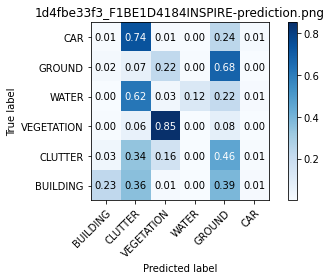

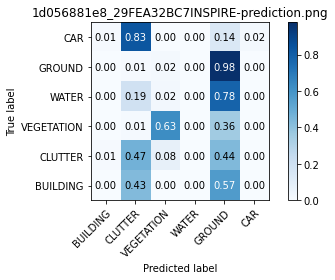

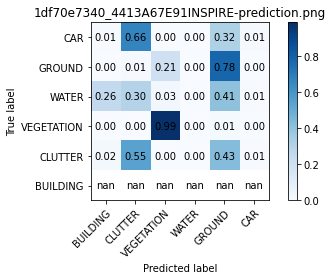

In [ ]:
import os
import cv2
import sys
sys.path.append(os.getcwd())

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score

import matplotlib.pyplot as plt
import numpy as np


def wherecolor(img, color, negate = False):

    k1 = (img[:, :, 0] == color[0])
    k2 = (img[:, :, 1] == color[1])
    k3 = (img[:, :, 2] == color[2])

    if negate:
        return np.where( not (k1 & k2 & k3) )
    else:
        return np.where( k1 & k2 & k3 )

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues,
                          savedir="predictions"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    labels_used = unique_labels(y_true, y_pred)
    # remove label 255 to fix this being present by accident
    if 255 in labels_used:
        labels_used.remove(255)
    classes = classes[labels_used]

    # Normalization with generate NaN where there are no ground label labels but there are predictions x/0
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    base, fname = os.path.split(title)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=fname,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.xlim([-0.5, cm.shape[1] - 0.5])
    plt.ylim([-0.5, cm.shape[0]- 0.5])

    fig.tight_layout()
    # save to directory
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
    savefile = title
    plt.savefig(savefile)
    return savefile, cm

def score_masks(labelfile, predictionfile):

    label = cv2.imread(labelfile)
    prediction = cv2.imread(predictionfile)

    shape = label.shape[:2]

    label_class = np.zeros(shape, dtype='uint8')
    pred_class  = np.zeros(shape, dtype='uint8')

    for color, category in INV_LABELMAP.items():
        locs = wherecolor(label, color)
        label_class[locs] = category

    for color, category in INV_LABELMAP.items():
        locs = wherecolor(prediction, color)
        pred_class[locs] = category

    label_class = label_class.reshape((label_class.shape[0] * label_class.shape[1]))
    pred_class = pred_class.reshape((pred_class.shape[0] * pred_class.shape[1]))

    # Remove all predictions where there is a IGNORE (magenta pixel) in the groud label and then shift labels down 1 index
    not_ignore_locs = np.where(label_class != 0)
    label_class = label_class[not_ignore_locs] - 1
    pred_class = pred_class[not_ignore_locs] - 1

    precision = precision_score(label_class, pred_class, average='weighted')
    recall = recall_score(label_class, pred_class, average='weighted')
    f1 = f1_score(label_class, pred_class, average='weighted')
    miou = jaccard_score(label_class, pred_class, average='macro')
    iou = jaccard_score(label_class, pred_class, labels=[0,1,2,3,4,5], average=None)
    print(f'precision={precision} recall={recall} f1={f1} miou={miou} iou per class={iou}')

    savefile, cm = plot_confusion_matrix(label_class, pred_class, np.array(LABELS), title=predictionfile)

    return precision, recall, f1, iou, miou, savefile

def score_predictions(dataset, basedir='predictions'):

    scores = []

    precision = []
    recall = []
    f1 = []
    miou = []
    miou_per_class = []
    predictions = []
    confusions = []

    #for scene in train_ids + val_ids + test_ids:
    for scene in test_ids:

        labelfile = f'/content/drive/MyDrive/dataset-sample/labels/{scene}-label.png'
        # predsfile = os.path.join(basedir, f"{scene}-prediction.png")
        predsfile = os.path.join('/content/wandb/latest-run/files/', f"{scene}-prediction.png")

        print('lbl' , labelfile)
        print('p' , predsfile)
        
        if not os.path.exists(labelfile):
            print('lbl file not exist ',labelfile )
            continue

        if not os.path.exists(predsfile):
            print('prid file not exist ',predsfile )
            continue

        a, b, c, iou, m, savefile = score_masks(labelfile, predsfile)

        precision.append(a)
        recall.append(b)
        f1.append(c)
        miou.append(m)
        print(f"Length of iou array is: {len(iou)} for {scene}")
        sys.stdout.flush()
        if len(miou_per_class) == 0:
            miou_per_class = np.array([iou])
        else:
            iou = np.array([iou])
            miou_per_class = np.append(miou_per_class, iou, axis=0)

        predictions.append(predsfile)
        confusions.append(savefile)

    # Compute test set scores
    scores = {
        'mean_iou' : np.mean(miou),
        'miou_class' : np.mean(miou_per_class, axis=0),
        'f1_mean' : np.mean(f1),
        'f1_std'  : np.std(f1),
        'pr_mean' : np.mean(precision),
        'pr_std'  : np.std(precision),
        're_mean' : np.mean(recall),
        're_std'  : np.std(recall),
    }

    return scores, zip(predictions, confusions)


if __name__ == '__main__':
    score_predictions('dataset-sample')


In [ ]:
# # scores all the test images compared to the ground truth labels then
# # send the scores (f1, precision, recall) and prediction images to wandb
score, _ = score_predictions(dataset, basedir=wandb.run.dir)
print(score)
wandb.log(score)

lbl /content/drive/MyDrive/dataset-sample/labels/1d4fbe33f3_F1BE1D4184INSPIRE-label.png
p /content/wandb/latest-run/files/1d4fbe33f3_F1BE1D4184INSPIRE-prediction.png


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision=0.4424033262403994 recall=0.0030326199045992196 f1=0.006023946404095574 miou=0.0008273774350682779 iou per class=[0.         0.         0.         0.         0.00579164 0.        ]


AttributeError: ignored